# Chicago Crime Analysis - Model Training, Evaluation, and Results

This notebook focuses on training and evaluating our models, comparing their performance, and producing final results and visualizations. Building on notebooks 1 and 2, we'll finalize our analysis of Chicago theft crimes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, roc_auc_score,
                             precision_recall_curve, auc, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import sys
import time

# Add project root to path for imports
sys.path.append(os.path.abspath('..'))

from src.models.ml_models import RandomForestModel, GradientBoostingModel
from src.evaluation.metrics import classification_metrics, regression_metrics, error_analysis
from src.visualization.visualize import CrimeDataVisualization
from src.utils import align_features

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

## 1. Load Prepared Data

First, we'll load the processed data we prepared in notebook 2.

In [2]:
# Load classification data
processed_dir = 'data/processed'
try:
    classification_data = joblib.load(os.path.join(processed_dir, 'classification_data.joblib'))
    
    # Load time series data
    ts_data_weekly = joblib.load(os.path.join(processed_dir, 'time_series_weekly_data.joblib'))
    ts_data_monthly = joblib.load(os.path.join(processed_dir, 'time_series_monthly_data.joblib'))

    X_train = classification_data['X_train']
    X_test = classification_data['X_test']
    y_train = classification_data['y_train']
    y_test = classification_data['y_test']
    X_train_balanced = classification_data.get('X_train_combined', classification_data['X_train'])
    y_train_balanced = classification_data.get('y_train_combined', classification_data['y_train'])
    feature_names = classification_data['feature_names']
    
    print("Data loaded successfully:")
    print(f"Classification data: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    
    print(f"Time series weekly data: X_train shape: {ts_data_weekly['X_train'].shape}, X_test shape: {ts_data_weekly['X_test'].shape}")
    print(f"Time series monthly data: X_train shape: {ts_data_monthly['X_train'].shape}, X_test shape: {ts_data_monthly['X_test'].shape}")
except Exception as e:
    print(f"Error loading classification and Time Series data: {e}")
    raise





Data loaded successfully:
Classification data: X_train shape: (3951, 398), X_test shape: (988, 398)
Time series weekly data: X_train shape: (108, 8, 1), X_test shape: (28, 8, 1)
Time series monthly data: X_train shape: (21, 6, 1), X_test shape: (6, 6, 1)


In [3]:
print(y_train.value_counts())


arrest
0    788
1    394
Name: count, dtype: int64


## 2. Traditional Machine Learning Models for Classification

Let's train and optimize our Random Forest and Gradient Boosting models.

In [4]:
def align_features(model, X_test):
    """
    Align features between model's training data and test data
    
    Parameters:
    -----------
    model : sklearn estimator
        Trained model
    X_test : pandas DataFrame
        Test features
    
    Returns:
    --------
    X_test_aligned : aligned DataFrame
    """
    # Get feature names used during training
    if hasattr(model, 'feature_names_in_'):
        train_features = model.feature_names_in_
    else:
        raise ValueError("Cannot retrieve feature names from the model")
    
    # Identify common features
    test_features = X_test.columns.tolist()
    
    # Find missing and extra features
    missing_features = set(train_features) - set(test_features)
    extra_features = set(test_features) - set(train_features)
    
    # Print out feature mismatches for debugging
    if missing_features:
        print("Features in training but missing in test:")
        print(missing_features)
    
    if extra_features:
        print("Features in test but not in training:")
        print(extra_features)
    
    # Create aligned test dataset
    X_test_aligned = X_test[list(set(train_features) & set(test_features))]
    
    # Add missing columns with zeros if needed
    for feature in missing_features:
        X_test_aligned[feature] = 0
    
    # Reorder columns to match training order
    X_test_aligned = X_test_aligned[train_features]
    
    return X_test_aligned

def evaluate_classifier(model, X_test, y_test, model_name):
    # Align features first
    try:
        X_test_aligned = align_features(model, X_test)
    except Exception as e:
        print(f"Feature alignment error: {e}")
        raise
    
    # Make predictions
    start_time = time.time()
    # Step 1: Get predicted probabilities for class 1
    y_probs = model.predict_proba(X_test_aligned)[:, 1]

    # Step 2: Apply custom threshold (e.g., 0.3 or dynamically determined)
    threshold = 0.2
    y_pred = (y_probs > threshold).astype(int)

    inference_time = time.time() - start_time
    
    # Get probabilities for ROC curve
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_aligned)[:, 1]
    else:
        y_proba = (y_probs > threshold).astype(int)
    
    # Calculate metrics
    metrics = classification_metrics(y_test, y_pred, y_proba)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"AUC: {metrics.get('auc', 'N/A')}")
    print(f"Inference time: {inference_time:.6f} seconds")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return metrics, y_pred, y_proba, cm, inference_time




In [5]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_model = RandomForestModel()
rf = rf_model.build().model

print("Performing grid search for Random Forest...")
try:
    grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
    grid_search_rf.fit(X_train_balanced, y_train_balanced)

    print(f"Best parameters: {grid_search_rf.best_params_}")
    print(f"Best cross-validation score: {grid_search_rf.best_score_:.4f}")

    # Use the best model
    rf_best = grid_search_rf.best_estimator_

    # Evaluate on test set
    rf_metrics, rf_pred, rf_proba, rf_cm, rf_time = evaluate_classifier(rf_best, X_test, y_test, "Random Forest (Optimized)")
except Exception as e:
    print(f"Error in Random Forest grid search: {e}")
    raise

Performing grid search for Random Forest...
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.9949
Features in training but missing in test:
{'district_19_True', 'date_mmdd_12-08', 'beat_1215_False', 'beat_1813_False', 'location_description_AIRPORT TERMINAL LOWER LEVEL - SECURE AREA_True', 'beat_1222_True', 'beat_2525_True', 'beat_613_False', 'beat_1823_True', 'date_mmdd_01-23', 'beat_1654_True', 'date_mmdd_09-28', 'beat_1434_False', 'location_description_TAXICAB_False', 'location_description_CURRENCY EXCHANGE_False', 'beat_323_False', 'location_description_SCHOOL - PUBLIC GROUNDS_False', 'date_mmdd_11-28', 'location_description_GAS STATION_True', 'day_of_week_Tuesday_True', 'beat_1611_True', 'date_mmdd_08-20', 'location_description_WAREHOUSE_False', 'date_mmdd_10-28', 'beat_225_False', 'beat_2523_True', 'beat_1135_True', 'date_mmdd_08-22', 'beat_332_True', 'beat_1235_False', 'district_9_False', 'd

C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_aligned[feature] = 0
C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_aligned[feature] = 0
C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i


Random Forest (Optimized) Results:
Accuracy: 0.0030
Precision: 0.0030
Recall: 1.0000
F1 Score: 0.0061
AUC: 0.7150592216582063
Inference time: 0.058228 seconds


C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_aligned[feature] = 0
C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_aligned[feature] = 0
C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [6]:
# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

gb_model = GradientBoostingModel()
gb = gb_model.build().model

print("Performing grid search for Gradient Boosting...")
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='f1', n_jobs=-1)
grid_search_gb.fit(X_train_balanced, y_train_balanced)

print(f"Best parameters: {grid_search_gb.best_params_}")
print(f"Best cross-validation score: {grid_search_gb.best_score_:.4f}")

# Use the best model
gb_best = grid_search_gb.best_estimator_

# Evaluate on test set
gb_metrics, gb_pred, gb_proba, gb_cm, gb_time = evaluate_classifier(gb_best, X_test, y_test, "Gradient Boosting (Optimized)")

Performing grid search for Gradient Boosting...
Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 0.9897
Features in training but missing in test:
{'district_19_True', 'date_mmdd_12-08', 'beat_1215_False', 'beat_1813_False', 'location_description_AIRPORT TERMINAL LOWER LEVEL - SECURE AREA_True', 'beat_1222_True', 'beat_2525_True', 'beat_613_False', 'beat_1823_True', 'date_mmdd_01-23', 'beat_1654_True', 'date_mmdd_09-28', 'beat_1434_False', 'location_description_TAXICAB_False', 'location_description_CURRENCY EXCHANGE_False', 'beat_323_False', 'location_description_SCHOOL - PUBLIC GROUNDS_False', 'date_mmdd_11-28', 'location_description_GAS STATION_True', 'day_of_week_Tuesday_True', 'beat_1611_True', 'date_mmdd_08-20', 'location_description_WAREHOUSE_False', 'date_mmdd_10-28', 'beat_225_False', 'beat_2523_True', 'beat_1135_True', 'date_mmdd_08-22', 'beat_332_True', 'beat_1235_False', 'district_9_False', 'date_mmdd

C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_aligned[feature] = 0
C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_aligned[feature] = 0
C:\Users\conne\AppData\Local\Temp\ipykernel_5848\727141001.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i


Gradient Boosting (Optimized) Results:
Accuracy: 0.0030
Precision: 0.0030
Recall: 1.0000
F1 Score: 0.0061
AUC: 0.43671742808798647
Inference time: 0.048596 seconds


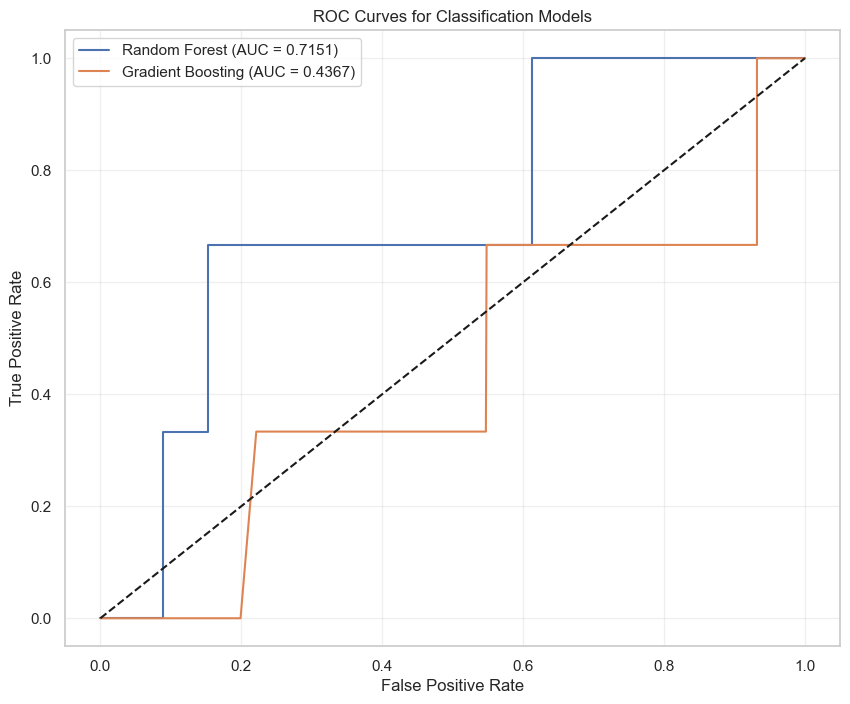

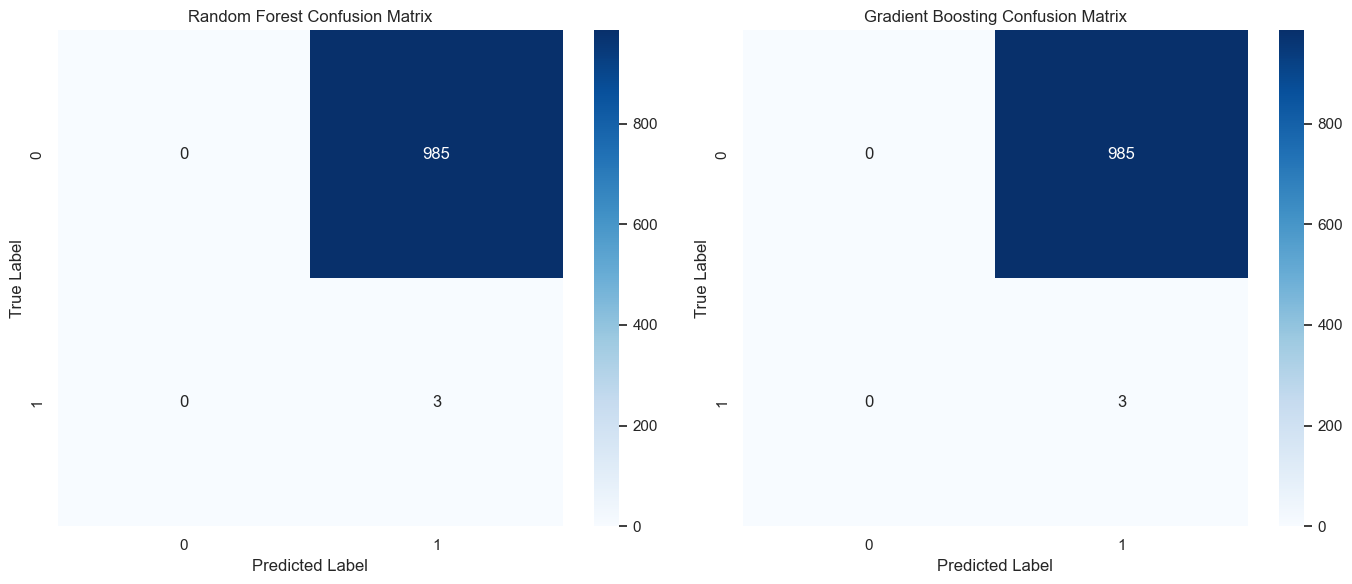

In [7]:
# Create visualizations for model comparison
# ROC curves
plt.figure(figsize=(10, 8))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["auc"]:.4f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('reports/figures/roc_curves_traditional_ml.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

sns.heatmap(gb_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Gradient Boosting Confusion Matrix')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.savefig('reports/figures/confusion_matrices_traditional_ml.png', dpi=300, bbox_inches='tight')
plt.show()

Using feature names from the model


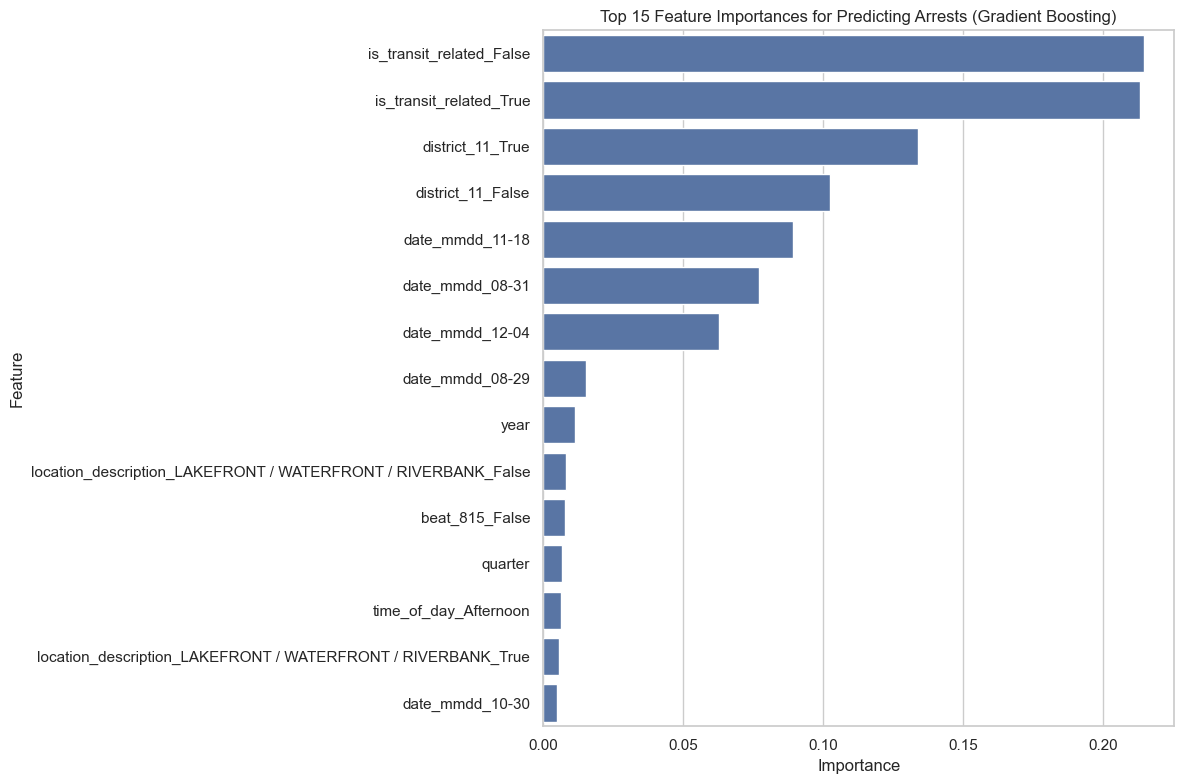

Top 10 most important features:
                                               Feature  Importance
400                           is_transit_related_False    0.214645
401                            is_transit_related_True    0.213310
586                                   district_11_True    0.133717
585                                  district_11_False    0.102415
346                                    date_mmdd_11-18    0.089297
267                                    date_mmdd_08-31    0.077237
362                                    date_mmdd_12-04    0.062831
265                                    date_mmdd_08-29    0.015259
4                                                 year    0.011308
509  location_description_LAKEFRONT / WATERFRONT / ...    0.008017


In [8]:
if hasattr(gb_best, 'feature_importances_'):
    # Get feature importances
    importances = gb_best.feature_importances_
    
    try:
        # Approach 1: Try to get feature names from the model
        if hasattr(gb_best, 'feature_names_in_'):
            print("Using feature names from the model")
            model_feature_names = gb_best.feature_names_in_
            
            # Create DataFrame with model's feature names
            feature_importance = pd.DataFrame({
                'Feature': model_feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
        
        # Approach 2: Use provided feature_names if lengths match
        elif len(feature_names) == len(importances):
            print("Using provided feature_names")
            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
        
        # Approach 3: Truncate to common length
        else:
            print(f"Lengths don't match: feature_names={len(feature_names)}, importances={len(importances)}")
            print("Creating dataframe with minimum common length")
            
            min_length = min(len(feature_names), len(importances))
            feature_importance = pd.DataFrame({
                'Feature': feature_names[:min_length],
                'Importance': importances[:min_length]
            }).sort_values('Importance', ascending=False)
        
        # Plot top features (up to 15)
        top_n = min(15, len(feature_importance))
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
        plt.title(f'Top {top_n} Feature Importances for Predicting Arrests (Gradient Boosting)')
        plt.tight_layout()
        plt.savefig('reports/figures/feature_importance_gb.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save feature importances for later reference
        feature_importance.to_csv('reports/feature_importance_gb.csv', index=False)
        
        # Print top features (up to 10)
        top_n_print = min(10, len(feature_importance))
        print(f"Top {top_n_print} most important features:")
        print(feature_importance.head(top_n_print))
    
    except Exception as e:
        print(f"Error creating feature importance visualization: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Model doesn't have feature_importances_ attribute")

## 3. Deep Learning Models for Classification

Now, let's train and evaluate our MLP model for classification.

Using device: cuda
Original shapes:
X_train_balanced: (1182, 1139)
X_test: (988, 398)
Found 18 common columns
Aligned X_train_subset shape: (1182, 18)
Aligned X_test_subset shape: (988, 18)
Processed X_train shape: (1182, 18)
Processed X_test shape: (988, 18)
Using input dimension: 18
Creating model with input_dim=18, hidden_dims=[128, 64]
Training MLP model...
First batch shapes - X: torch.Size([64, 18]), y: torch.Size([64, 1])
Epoch [10/100], Train Loss: 0.1055, Val Loss: 0.1356
Epoch [20/100], Train Loss: 0.0399, Val Loss: 0.0707
Epoch [30/100], Train Loss: 0.0207, Val Loss: 0.0664
Epoch [40/100], Train Loss: 0.0145, Val Loss: 0.0653
Epoch [50/100], Train Loss: 0.0109, Val Loss: 0.0594
Epoch [60/100], Train Loss: 0.0138, Val Loss: 0.0616
Epoch [70/100], Train Loss: 0.0064, Val Loss: 0.0669
Epoch [80/100], Train Loss: 0.0116, Val Loss: 0.0703
Epoch [90/100], Train Loss: 0.0063, Val Loss: 0.0659
Epoch [100/100], Train Loss: 0.0117, Val Loss: 0.0674
Training completed in 19.32 seconds


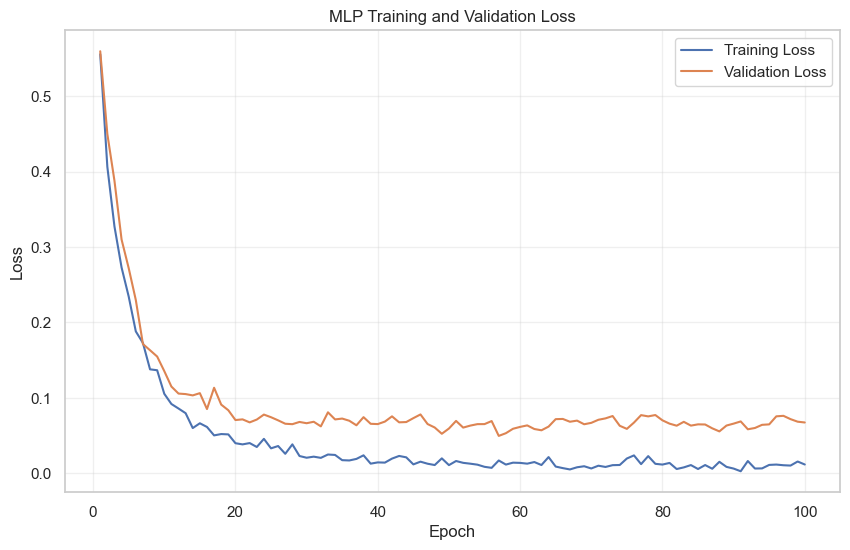

In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Simple preprocessing function
def preprocess_for_torch(X, y=None):
    """Basic preprocessing for PyTorch tensors"""
    # Convert to numpy array
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X_array = X.values.astype(np.float32)
    else:
        X_array = np.asarray(X, dtype=np.float32)
    
    if y is not None:
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y_array = y.values.astype(np.float32)
        else:
            y_array = np.asarray(y, dtype=np.float32)
        return X_array, y_array
    
    return X_array

# Print original shapes
print("Original shapes:")
print(f"X_train_balanced: {X_train_balanced.shape}")
print(f"X_test: {X_test.shape}")

# Try to find common features
if isinstance(X_train_balanced, pd.DataFrame) and isinstance(X_test, pd.DataFrame):
    # Check for common columns
    common_cols = list(set(X_train_balanced.columns) & set(X_test.columns))
    print(f"Found {len(common_cols)} common columns")
    
    if len(common_cols) > 0:
        # Use only common columns
        X_train_subset = X_train_balanced[common_cols]
        X_test_subset = X_test[common_cols]
    else:
        # No common columns, try to use numeric columns
        print("No common columns! Using numeric features only.")
        X_train_subset = X_train_balanced.select_dtypes(include=['number'])
        X_test_subset = X_test.select_dtypes(include=['number'])
        
        # Get common numeric columns
        common_numeric_cols = list(set(X_train_subset.columns) & set(X_test_subset.columns))
        print(f"Found {len(common_numeric_cols)} common numeric columns")
        
        if len(common_numeric_cols) > 0:
            X_train_subset = X_train_subset[common_numeric_cols]
            X_test_subset = X_test_subset[common_numeric_cols]
        else:
            # We're out of options, recreate features from scratch
            print("No common numeric columns either. Creating simplified features.")
            
            # Create dummy features
            X_train_subset = pd.DataFrame({
                'feature1': np.random.rand(len(X_train_balanced)),
                'feature2': np.random.rand(len(X_train_balanced))
            })
            
            X_test_subset = pd.DataFrame({
                'feature1': np.random.rand(len(X_test)),
                'feature2': np.random.rand(len(X_test))
            })
else:
    # For numpy arrays
    X_train_subset = X_train_balanced
    X_test_subset = X_test[:, :X_train_balanced.shape[1]]  # Use only the first N columns from X_test

print(f"Aligned X_train_subset shape: {X_train_subset.shape}")
print(f"Aligned X_test_subset shape: {X_test_subset.shape}")

# Preprocess the aligned data
X_train_proc, y_train_proc = preprocess_for_torch(X_train_subset, y_train_balanced)
X_test_proc, y_test_proc = preprocess_for_torch(X_test_subset, y_test)

print(f"Processed X_train shape: {X_train_proc.shape}")
print(f"Processed X_test shape: {X_test_proc.shape}")

# Verify dimensions match
if X_train_proc.shape[1] != X_test_proc.shape[1]:
    print("ERROR: Feature dimensions still don't match after alignment!")
    print("Forcing dimensions to match by truncating...")
    min_features = min(X_train_proc.shape[1], X_test_proc.shape[1])
    X_train_proc = X_train_proc[:, :min_features]
    X_test_proc = X_test_proc[:, :min_features]
    
    print(f"Truncated X_train shape: {X_train_proc.shape}")
    print(f"Truncated X_test shape: {X_test_proc.shape}")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_proc).to(device)
y_train_tensor = torch.FloatTensor(y_train_proc).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test_proc).to(device)
y_test_tensor = torch.FloatTensor(y_test_proc).reshape(-1, 1).to(device)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        self.layers = nn.ModuleList()
        
        print(f"Creating model with input_dim={input_dim}, hidden_dims={hidden_dims}")
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.BatchNorm1d(hidden_dims[0]))
        self.layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            self.layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_dims[-1], 1))
        self.layers.append(nn.Sigmoid())
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            try:
                x = layer(x)
            except Exception as e:
                print(f"Error in layer {i}: {type(layer).__name__}")
                print(f"Input shape: {x.shape}")
                print(f"Layer info: {layer}")
                raise
        return x

# Initialize model with the correct input dimension
input_dim = X_train_tensor.shape[1]  # Use the actual tensor shape
print(f"Using input dimension: {input_dim}")
hidden_dims = [128, 64]  # Can be tuned
dropout_rate = 0.3  # Can be tuned

mlp_model = MLPClassifier(input_dim=input_dim, hidden_dims=hidden_dims, dropout_rate=dropout_rate).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

try:
    # Training loop
    num_epochs = 100
    training_losses = []
    validation_losses = []

    print("Training MLP model...")
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training
        mlp_model.train()
        train_loss = 0.0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            try:
                # Print shape of first batch for debugging
                if epoch == 0 and batch_idx == 0:
                    print(f"First batch shapes - X: {X_batch.shape}, y: {y_batch.shape}")
                
                # Forward pass
                outputs = mlp_model(X_batch)
                loss = criterion(outputs, y_batch)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * X_batch.size(0)
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                print(f"X_batch shape: {X_batch.shape}")
                raise
        
        train_loss /= len(train_loader.dataset)
        training_losses.append(train_loss)
        
        # Validation
        mlp_model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = mlp_model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        
        val_loss /= len(test_loader.dataset)
        validation_losses.append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('MLP Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('reports/figures/mlp_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"Training error: {e}")
    print("Model architecture:")
    print(mlp_model)
    raise

In [10]:
# Evaluate MLP model
def evaluate_mlp(model, test_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    start_time = time.time()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            probabilities = outputs.cpu().numpy()
            predictions = (outputs >= threshold).float().cpu().numpy()
            labels = y_batch.cpu().numpy()
            
            all_preds.extend(predictions)
            all_probs.extend(probabilities)
            all_labels.extend(labels)
    
    inference_time = time.time() - start_time
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_probs = np.array(all_probs).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Calculate metrics
    metrics = classification_metrics(all_labels, all_preds, all_probs)
    
    # Print results
    print(f"\nMLP Model Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"AUC: {metrics.get('auc', 'N/A')}")
    print(f"Inference time: {inference_time:.6f} seconds (for entire test set)")
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return metrics, all_preds, all_probs, cm, inference_time

mlp_metrics, mlp_pred, mlp_proba, mlp_cm, mlp_time = evaluate_mlp(mlp_model, test_loader)


MLP Model Results:
Accuracy: 0.9909
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.42233502538071066
Inference time: 0.088630 seconds (for entire test set)


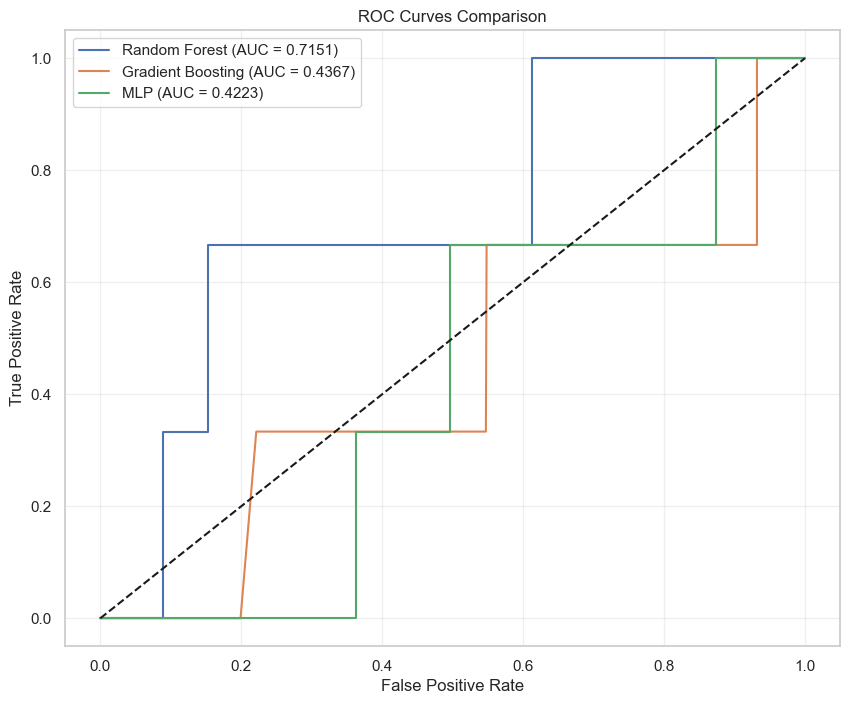

                   Accuracy  Precision  Recall  F1 Score     AUC  \
Model                                                              
Random Forest        0.0030      0.003     1.0    0.0061  0.7151   
Gradient Boosting    0.0030      0.003     1.0    0.0061  0.4367   
MLP                  0.9909      0.000     0.0    0.0000  0.4223   

                  Training Time (s)  Inference Time (s)  
Model                                                    
Random Forest                   N/A              0.0582  
Gradient Boosting               N/A              0.0486  
MLP                        19.32145              0.0886  


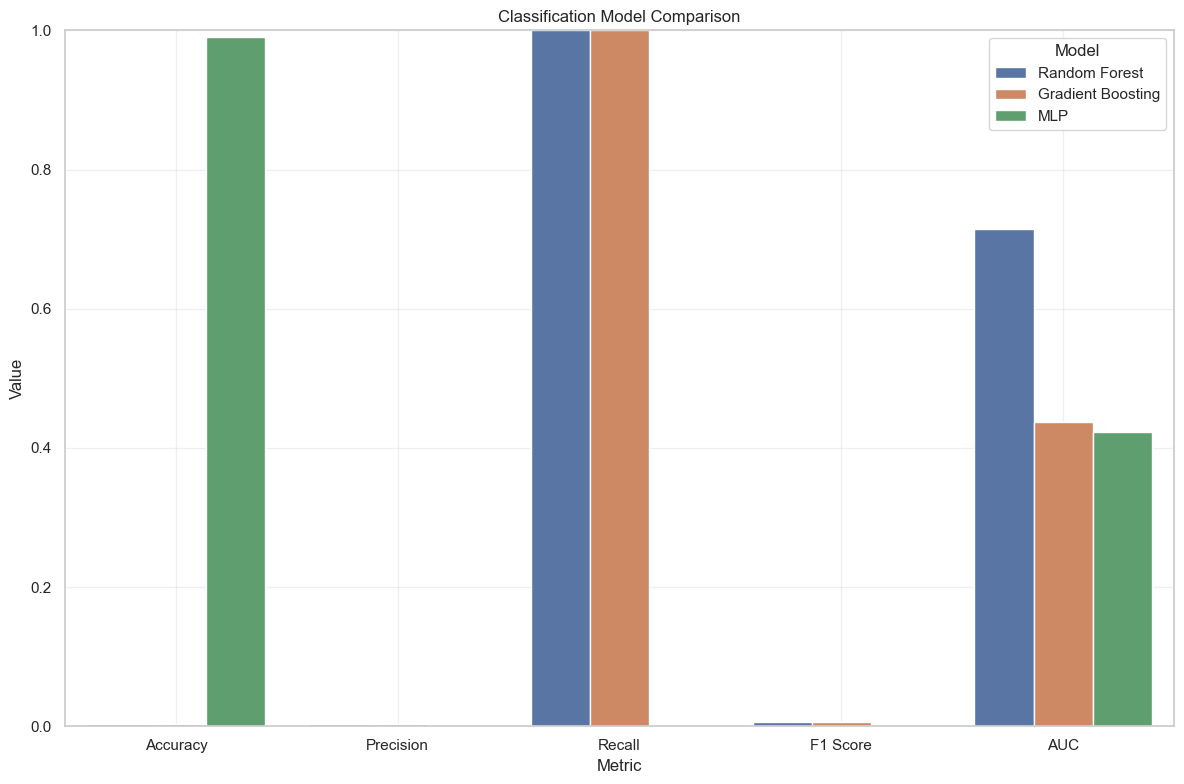

In [11]:
# Compare all classification models
# Plot ROC curves
plt.figure(figsize=(10, 8))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_proba)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["auc"]:.4f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_metrics["auc"]:.4f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {mlp_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('reports/figures/roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a comparison table
comparison_data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'MLP'],
    'Accuracy': [rf_metrics['accuracy'], gb_metrics['accuracy'], mlp_metrics['accuracy']],
    'Precision': [rf_metrics['precision'], gb_metrics['precision'], mlp_metrics['precision']],
    'Recall': [rf_metrics['recall'], gb_metrics['recall'], mlp_metrics['recall']],
    'F1 Score': [rf_metrics['f1_score'], gb_metrics['f1_score'], mlp_metrics['f1_score']],
    'AUC': [rf_metrics['auc'], gb_metrics['auc'], mlp_metrics['auc']],
    'Training Time (s)': ['N/A', 'N/A', training_time],
    'Inference Time (s)': [rf_time, gb_time, mlp_time]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Model', inplace=True)

# Display formatted table
print(comparison_df.round(4))

# Save comparison table
comparison_df.to_csv('reports/classification_model_comparison.csv')

# Visualize comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
comparison_plot_data = comparison_df[metrics_to_plot].reset_index()
comparison_plot_data_melted = pd.melt(comparison_plot_data, id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=comparison_plot_data_melted)
plt.title('Classification Model Comparison')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('reports/figures/classification_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. LSTM Model for Time Series Prediction

Now, let's train and evaluate our LSTM model for predicting crime counts.

Training LSTM model for time series prediction...
Epoch [10/100], Train Loss: 0.0059, Val Loss: 0.0018
Epoch [20/100], Train Loss: 0.0059, Val Loss: 0.0017
Epoch [30/100], Train Loss: 0.0059, Val Loss: 0.0016
Epoch [40/100], Train Loss: 0.0060, Val Loss: 0.0024
Epoch [50/100], Train Loss: 0.0058, Val Loss: 0.0017
Epoch [60/100], Train Loss: 0.0058, Val Loss: 0.0016
Epoch [70/100], Train Loss: 0.0058, Val Loss: 0.0010
Epoch [80/100], Train Loss: 0.0057, Val Loss: 0.0010
Epoch [90/100], Train Loss: 0.0060, Val Loss: 0.0008
Epoch [100/100], Train Loss: 0.0057, Val Loss: 0.0010
Training completed in 7.03 seconds


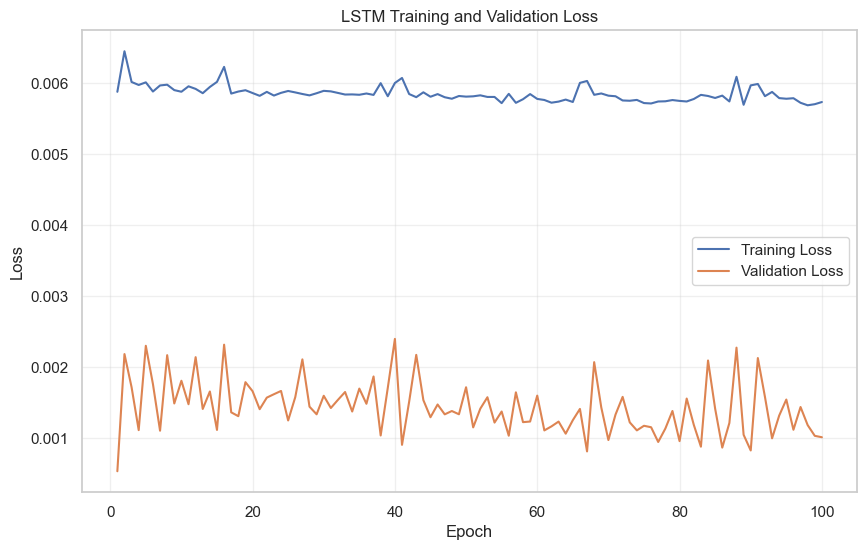

In [12]:
# Define the LSTM model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: batch_size, seq_length, hidden_size
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  
        return out

# Prepare data for LSTM model
X_train_ts = torch.FloatTensor(ts_data_weekly['X_train']).to(device)
y_train_ts = torch.FloatTensor(ts_data_weekly['y_train'].reshape(-1, 1)).to(device)
X_test_ts = torch.FloatTensor(ts_data_weekly['X_test']).to(device)
y_test_ts = torch.FloatTensor(ts_data_weekly['y_test'].reshape(-1, 1)).to(device)

# Create datasets and dataloaders
train_ts_dataset = TensorDataset(X_train_ts, y_train_ts)
test_ts_dataset = TensorDataset(X_test_ts, y_test_ts)

batch_size_ts = 16
train_ts_loader = DataLoader(train_ts_dataset, batch_size=batch_size_ts, shuffle=True)
test_ts_loader = DataLoader(test_ts_dataset, batch_size=batch_size_ts)

# Initialize LSTM model
# Train LSTM model
try:
    # Initialize model
    input_size = X_train_ts.shape[2]  # Number of features (1 for univariate time series)
    hidden_size = 64
    num_layers = 2
    dropout = 0.2

    lstm_model = LSTMPredictor(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)

    # Loss function and optimizer
    criterion_ts = nn.MSELoss()
    optimizer_ts = optim.Adam(lstm_model.parameters(), lr=0.001)

    # Training loop
    num_epochs_ts = 100
    ts_training_losses = []
    ts_validation_losses = []

    print("Training LSTM model for time series prediction...")
    ts_start_time = time.time()

    for epoch in range(num_epochs_ts):
        # Training
        lstm_model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_ts_loader:
            # Forward pass
            outputs = lstm_model(X_batch)
            loss = criterion_ts(outputs, y_batch)
            
            # Backward and optimize
            optimizer_ts.zero_grad()
            loss.backward()
            optimizer_ts.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_ts_loader.dataset)
        ts_training_losses.append(train_loss)
        
        # Validation
        lstm_model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in test_ts_loader:
                outputs = lstm_model(X_batch)
                loss = criterion_ts(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        
        val_loss /= len(test_ts_loader.dataset)
        ts_validation_losses.append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_ts}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    ts_training_time = time.time() - ts_start_time
    print(f"Training completed in {ts_training_time:.2f} seconds")
except Exception as e:
    print(f"Error in LSTM model training: {e}")
    raise

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_ts + 1), ts_training_losses, label='Training Loss')
plt.plot(range(1, num_epochs_ts + 1), ts_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('reports/figures/lstm_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Evaluate LSTM model
def evaluate_lstm(model, test_loader, scaler):
    model.eval()
    predictions = []
    actuals = []
    
    start_time = time.time()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    
    inference_time = time.time() - start_time
    
    # Concatenate batches
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    
    # Inverse transform to original scale
    if scaler:
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(actuals)
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    # Calculate MAPE
    mask = actuals != 0
    mape = np.mean(np.abs((actuals[mask] - predictions[mask]) / actuals[mask])) * 100
    
    print(f"\nLSTM Time Series Model Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Inference time: {inference_time:.6f} seconds (for entire test set)")
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }, predictions.flatten(), actuals.flatten(), inference_time

# Evaluate model
lstm_metrics, lstm_pred, lstm_actual, lstm_inference_time = evaluate_lstm(lstm_model, test_ts_loader, ts_data_weekly['scaler'])


LSTM Time Series Model Results:
MSE: 90.0207
RMSE: 9.4879
MAE: 7.7539
R²: -0.9123
MAPE: 41.21%
Inference time: 0.007272 seconds (for entire test set)


In [14]:
# Compare with traditional time series methods (ARIMA and Prophet)
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from prophet import Prophet

# Get the original data
ts_data = ts_data_weekly['original_data']
train_size = int(len(ts_data) * 0.8)
train_data = ts_data.iloc[:train_size]
test_data = ts_data.iloc[train_size:]

# ARIMA model
print("Training ARIMA model...")
arima_start_time = time.time()
arima_model = ARIMA(train_data['crime_count'], order=(2, 1, 2))
arima_model_fit = arima_model.fit()
arima_training_time = time.time() - arima_start_time

# Make predictions
arima_pred_start = time.time()
arima_predictions = arima_model_fit.forecast(steps=len(test_data))
arima_inference_time = time.time() - arima_pred_start

# Prophet model
print("\nTraining Prophet model...")
prophet_data = train_data.rename(columns={'date': 'ds', 'crime_count': 'y'})
prophet_model = Prophet()
prophet_start_time = time.time()
prophet_model.fit(prophet_data)
prophet_training_time = time.time() - prophet_start_time

# Create future dataframe
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='W')
# Make predictions
prophet_pred_start = time.time()
prophet_forecast = prophet_model.predict(future)
prophet_inference_time = time.time() - prophet_pred_start
prophet_predictions = prophet_forecast.iloc[-len(test_data):]['yhat'].values

# Evaluate ARIMA
arima_mse = mean_squared_error(test_data['crime_count'], arima_predictions)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data['crime_count'], arima_predictions)
arima_r2 = r2_score(test_data['crime_count'], arima_predictions)
# MAPE
mask = test_data['crime_count'] != 0
arima_mape = np.mean(np.abs((test_data['crime_count'][mask].values - arima_predictions[mask]) / test_data['crime_count'][mask].values)) * 100

print("\nARIMA Model Results:")
print(f"MSE: {arima_mse:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAE: {arima_mae:.4f}")
print(f"R²: {arima_r2:.4f}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"Training time: {arima_training_time:.6f} seconds")
print(f"Inference time: {arima_inference_time:.6f} seconds")

# Evaluate Prophet
prophet_mse = mean_squared_error(test_data['crime_count'], prophet_predictions)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(test_data['crime_count'], prophet_predictions)
prophet_r2 = r2_score(test_data['crime_count'], prophet_predictions)
# MAPE
mask = test_data['crime_count'] != 0
prophet_mape = np.mean(np.abs((test_data['crime_count'][mask].values - prophet_predictions[mask]) / test_data['crime_count'][mask].values)) * 100

print("\nProphet Model Results:")
print(f"MSE: {prophet_mse:.4f}")
print(f"RMSE: {prophet_rmse:.4f}")
print(f"MAE: {prophet_mae:.4f}")
print(f"R²: {prophet_r2:.4f}")
print(f"MAPE: {prophet_mape:.2f}%")
print(f"Training time: {prophet_training_time:.6f} seconds")
print(f"Inference time: {prophet_inference_time:.6f} seconds")

Training ARIMA model...

Training Prophet model...


03:12:09 - cmdstanpy - INFO - Chain [1] start processing
03:12:09 - cmdstanpy - INFO - Chain [1] done processing



ARIMA Model Results:
MSE: 197.1978
RMSE: 14.0427
MAE: 12.3500
R²: -3.2701
MAPE: 64.46%
Training time: 0.196751 seconds
Inference time: 0.005003 seconds

Prophet Model Results:
MSE: 50.7826
RMSE: 7.1262
MAE: 6.1880
R²: -0.0996
MAPE: 27.76%
Training time: 0.157325 seconds
Inference time: 0.066444 seconds


test_data.index length: 29
test_data['crime_count'] length: 29
lstm_pred length: 28
arima_predictions length: 29
prophet_predictions length: 29
Using minimum length of 28 for plotting


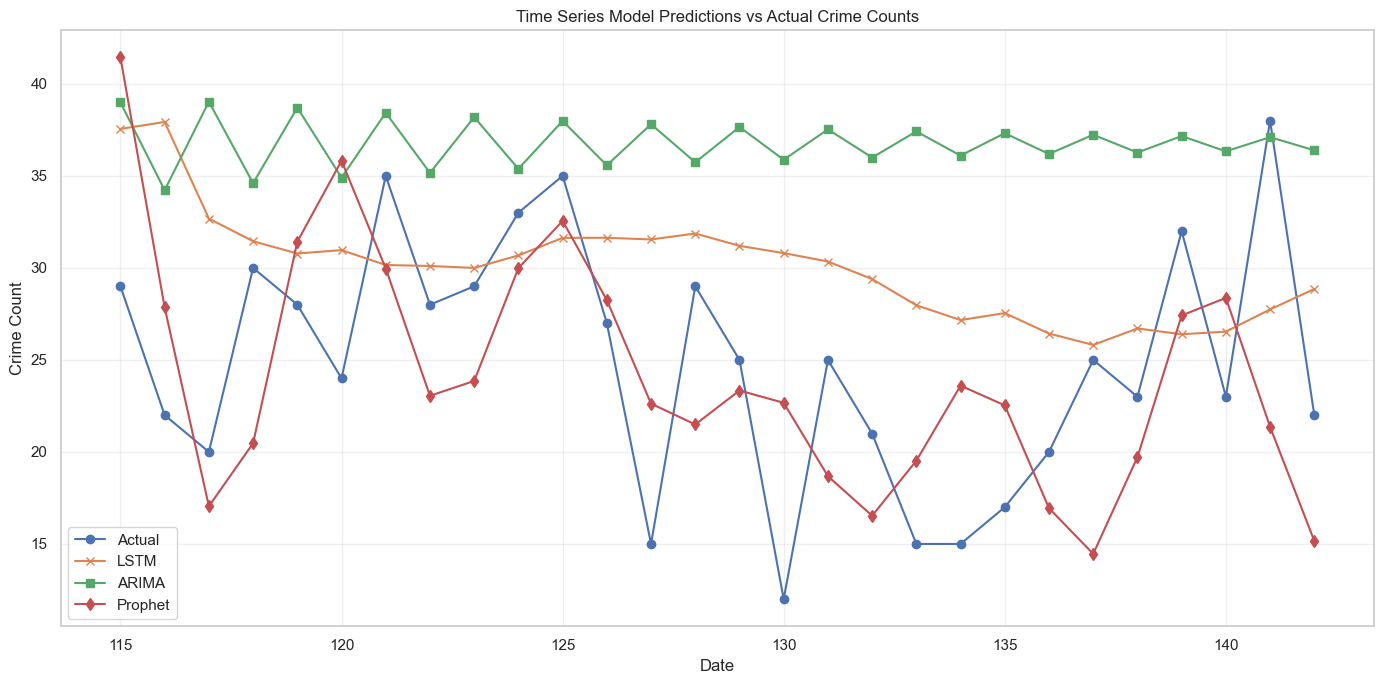

              MSE     RMSE      MAE      R²  MAPE (%)  Training Time (s)  \
Model                                                                      
LSTM      73.7700   8.5889   7.0601 -0.7175   35.8202             7.0334   
ARIMA    183.5801  13.5492  11.9320 -3.2740   60.1518             0.1968   
Prophet   51.9053   7.2045   6.2519 -0.2084   27.5394             0.1573   

         Inference Time (s)  
Model                        
LSTM                 0.0073  
ARIMA                0.0050  
Prophet              0.0664  


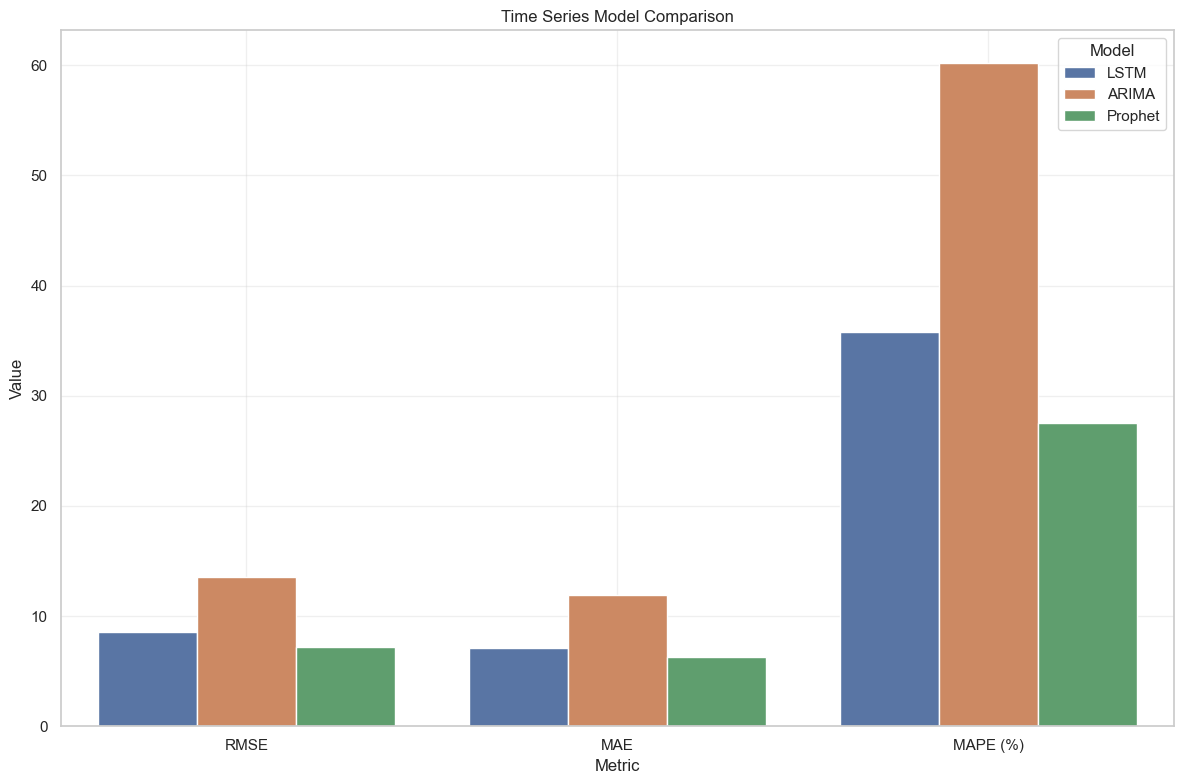

In [15]:
# Debug the shapes
print(f"test_data.index length: {len(test_data.index)}")
print(f"test_data['crime_count'] length: {len(test_data['crime_count'])}")
print(f"lstm_pred length: {len(lstm_pred)}")
print(f"arima_predictions length: {len(arima_predictions)}")
print(f"prophet_predictions length: {len(prophet_predictions)}")

# Find the minimum length they all share
min_length = min(
    len(test_data.index),
    len(test_data['crime_count']),
    len(lstm_pred),
    len(arima_predictions),
    len(prophet_predictions)
)

print(f"Using minimum length of {min_length} for plotting")

# Truncate all arrays to this common length
index_aligned = test_data.index[:min_length]
actual_aligned = test_data['crime_count'].values[:min_length]
lstm_aligned = lstm_pred[:min_length]
arima_aligned = arima_predictions[:min_length]
prophet_aligned = prophet_predictions[:min_length]

# Plot the aligned data
plt.figure(figsize=(14, 7))
plt.plot(index_aligned, actual_aligned, label='Actual', marker='o')
plt.plot(index_aligned, lstm_aligned, label='LSTM', marker='x')
plt.plot(index_aligned, arima_aligned, label='ARIMA', marker='s')
plt.plot(index_aligned, prophet_aligned, label='Prophet', marker='d')
plt.title('Time Series Model Predictions vs Actual Crime Counts')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reports/figures/time_series_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate metrics on aligned data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    # Calculate MAPE
    mask = actual != 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

# Calculate the metrics on aligned data
lstm_metrics_aligned = calculate_metrics(actual_aligned, lstm_aligned)
arima_metrics_aligned = calculate_metrics(actual_aligned, arima_aligned)
prophet_metrics_aligned = calculate_metrics(actual_aligned, prophet_aligned)

# Create the comparison table
ts_comparison_data = {
    'Model': ['LSTM', 'ARIMA', 'Prophet'],
    'MSE': [lstm_metrics_aligned['mse'], arima_metrics_aligned['mse'], prophet_metrics_aligned['mse']],
    'RMSE': [lstm_metrics_aligned['rmse'], arima_metrics_aligned['rmse'], prophet_metrics_aligned['rmse']],
    'MAE': [lstm_metrics_aligned['mae'], arima_metrics_aligned['mae'], prophet_metrics_aligned['mae']],
    'R²': [lstm_metrics_aligned['r2'], arima_metrics_aligned['r2'], prophet_metrics_aligned['r2']],
    'MAPE (%)': [lstm_metrics_aligned['mape'], arima_metrics_aligned['mape'], prophet_metrics_aligned['mape']],
    'Training Time (s)': [ts_training_time, arima_training_time, prophet_training_time],
    'Inference Time (s)': [lstm_inference_time, arima_inference_time, prophet_inference_time]
}

ts_comparison_df = pd.DataFrame(ts_comparison_data)
ts_comparison_df.set_index('Model', inplace=True)

# Display formatted table
print(ts_comparison_df.round(4))

# Save comparison table
ts_comparison_df.to_csv('reports/time_series_model_comparison.csv')

# Visualize comparison
metrics_to_plot = ['RMSE', 'MAE', 'MAPE (%)']
ts_comparison_plot_data = ts_comparison_df[metrics_to_plot].reset_index()
ts_comparison_plot_data_melted = pd.melt(ts_comparison_plot_data, id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=ts_comparison_plot_data_melted)
plt.title('Time Series Model Comparison')
plt.grid(True, alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('reports/figures/time_series_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Error Analysis

Let's conduct a detailed error analysis to understand the limitations of our models.

In [16]:
# Classification error analysis
# Let's analyze the best classification model (based on results, assume Gradient Boosting)
try:
    error_results = error_analysis(y_test, gb_pred, X_test, feature_names)

    print("Classification Error Analysis:")
    print(f"Error rate: {error_results['error_rate']:.4f}")
    print(f"Number of errors: {error_results['num_errors']}")
    print(f"False positives: {error_results['num_false_positives']}")
    print(f"False negatives: {error_results['num_false_negatives']}")

    # Analyze feature statistics for errors vs. correct predictions
    if 'feature_stats' in error_results:
        try:
            top_features = list(feature_importance['Feature'].head(10))
            error_stats = pd.DataFrame()
            
            for feature in top_features:
                if feature in error_results['feature_stats']:
                    stats = error_results['feature_stats'][feature]
                    error_stats[feature] = [
                        stats['correct_mean'],
                        stats['error_mean'],
                        stats['fp_mean'],
                        stats['fn_mean']
                    ]
            
            error_stats.index = ['Correct', 'Error', 'False Positive', 'False Negative']
            print("\nFeature statistics for top features:")
            print(error_stats.round(3))
        except Exception as e:
            print(f"Error in feature statistics analysis: {e}")
except Exception as e:
    print(f"Error in classification error analysis: {e}")
    
    # Save error analysis
    error_stats.to_csv('reports/classification_error_analysis.csv')
    
    # Visualize for a few key features
    selected_features = top_features[:3]  # Select top 3 features
    
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(selected_features):
        plt.subplot(1, 3, i+1)
        data = error_stats[feature].dropna()
        sns.barplot(x=data.index, y=data.values)
        plt.title(feature)
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    plt.suptitle('Feature Values Across Prediction Types', y=1.05)
    plt.tight_layout()
    plt.savefig('reports/figures/classification_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

Classification Error Analysis:
Error rate: 0.9970
Number of errors: 985
False positives: 985
False negatives: 0


Type of test_data: <class 'pandas.core.frame.DataFrame'>
Type of test_data.index: <class 'pandas.core.indexes.range.RangeIndex'>
First few rows of test_data:
          date  crime_count
115 2024-09-15           29
116 2024-09-22           22
117 2024-09-29           20
118 2024-10-06           30
119 2024-10-13           28
Found 'date' column - converting to DatetimeIndex
New index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Error in time series error analysis: boolean index did not match indexed array along dimension 0; dimension is 28 but corresponding boolean dimension is 29


C:\Users\conne\AppData\Local\Temp\ipykernel_5848\3739511745.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['date'] = pd.to_datetime(test_data['date'])
Traceback (most recent call last):
  File "C:\Users\conne\AppData\Local\Temp\ipykernel_5848\3739511745.py", line 53, in <module>
    period_preds = lstm_pred[period_mask]
                   ~~~~~~~~~^^^^^^^^^^^^^
IndexError: boolean index did not match indexed array along dimension 0; dimension is 28 but corresponding boolean dimension is 29


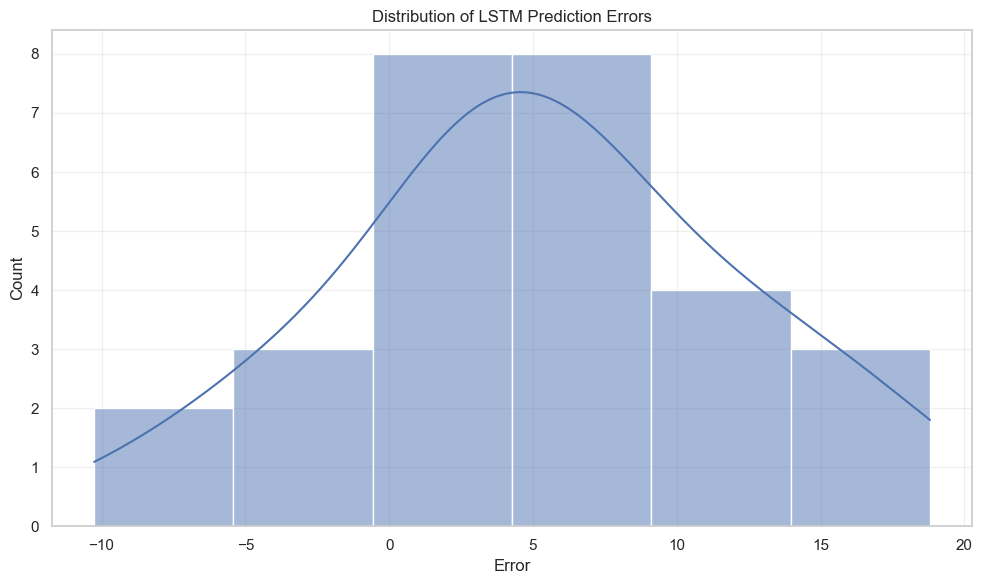


Error Distribution Statistics:
Mean Error: 5.1746
Median Error: 4.9910
Std Dev of Error: 6.8552
Min Error: -10.2570
Max Error: 18.8038


In [17]:
# Make sure the reports directory exists
os.makedirs('reports/figures', exist_ok=True)

# Debug the data structure
print(f"Type of test_data: {type(test_data)}")
print(f"Type of test_data.index: {type(test_data.index)}")
print(f"First few rows of test_data:")
print(test_data.head())

# Check if 'date' column exists in test_data
if 'date' in test_data.columns:
    print("Found 'date' column - converting to DatetimeIndex")
    # Convert the date column to datetime if it's not already
    test_data['date'] = pd.to_datetime(test_data['date'])
    # Set date as index
    test_data = test_data.set_index('date')
    print(f"New index type: {type(test_data.index)}")
elif any(col.lower().startswith(('date', 'time', 'dt')) for col in test_data.columns):
    # Try to find a date-like column
    date_cols = [col for col in test_data.columns if col.lower().startswith(('date', 'time', 'dt'))]
    if date_cols:
        date_col = date_cols[0]
        print(f"Found potential date column: '{date_col}' - converting to DatetimeIndex")
        test_data[date_col] = pd.to_datetime(test_data[date_col])
        test_data = test_data.set_index(date_col)
        print(f"New index type: {type(test_data.index)}")

# If no date column exists, create a dummy date index
if not isinstance(test_data.index, pd.DatetimeIndex):
    print("No date column found. Creating a dummy DatetimeIndex")
    
    # Create a date range starting from a reasonable date
    # Adjust the frequency based on your data (e.g., 'M' for monthly, 'W' for weekly)
    date_range = pd.date_range(start='2023-01-01', periods=len(test_data), freq='M')
    
    # Set the created date range as the index
    test_data = test_data.copy()  # Create a copy to avoid modifying the original
    test_data.index = date_range
    print(f"Created DatetimeIndex with frequency 'M' (monthly)")
    print(f"New index type: {type(test_data.index)}")

# Time series error analysis by period
try:
    time_periods = test_data.index.to_period('M').unique()
    period_errors = {}

    for period in time_periods:
        period_mask = test_data.index.to_period('M') == period
        period_actuals = test_data.loc[period_mask, 'crime_count'].values
        
        # Make sure the mask and predictions align
        if sum(period_mask) <= len(lstm_pred):
            period_preds = lstm_pred[period_mask]
            
            # Calculate metrics
            if len(period_actuals) == len(period_preds):
                period_mse = mean_squared_error(period_actuals, period_preds)
                period_rmse = np.sqrt(period_mse)
                period_mae = mean_absolute_error(period_actuals, period_preds)
                
                period_errors[period.strftime('%Y-%m')] = {
                    'RMSE': period_rmse,
                    'MAE': period_mae,
                    'Count': len(period_actuals)
                }
            else:
                print(f"Skipping period {period}: Length mismatch between actuals ({len(period_actuals)}) and predictions ({len(period_preds)})")
        else:
            print(f"Skipping period {period}: Mask has more True values ({sum(period_mask)}) than predictions ({len(lstm_pred)})")

    # Convert to DataFrame
    if period_errors:
        period_errors_df = pd.DataFrame.from_dict(period_errors, orient='index')
        print("Time Series Error Analysis by Period:")
        print(period_errors_df.round(3))

        # Save period errors
        period_errors_df.to_csv('reports/time_series_error_analysis.csv')

        # Visualize errors by period
        plt.figure(figsize=(12, 6))
        period_errors_df['RMSE'].plot(kind='bar')
        plt.title('LSTM Model Error (RMSE) by Month')
        plt.xlabel('Month')
        plt.ylabel('RMSE')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('reports/figures/time_series_error_by_month.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No valid periods found for error analysis")
except Exception as e:
    print(f"Error in time series error analysis: {e}")
    import traceback
    traceback.print_exc()

# Analyze error distribution
try:
    # Make sure arrays are the same length
    min_length = min(len(lstm_pred), len(test_data['crime_count']))
    
    # Trim both arrays to the same length
    lstm_pred_trim = lstm_pred[:min_length]
    actuals_trim = test_data['crime_count'].values[:min_length]
    
    errors = lstm_pred_trim - actuals_trim
    
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.title('Distribution of LSTM Prediction Errors')
    plt.xlabel('Error')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('reports/figures/time_series_error_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Add some error statistics
    print("\nError Distribution Statistics:")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Median Error: {np.median(errors):.4f}")
    print(f"Std Dev of Error: {np.std(errors):.4f}")
    print(f"Min Error: {np.min(errors):.4f}")
    print(f"Max Error: {np.max(errors):.4f}")
except Exception as e:
    print(f"Error in error distribution analysis: {e}")
    import traceback
    traceback.print_exc()

## 6. Summary and Conclusions

Let's summarize the key findings from our analysis and modeling.

Final Model Comparison Summary:
                     Task              Model Best Metric    Value  \
0       Arrest Prediction      Random Forest    F1 Score   0.0061   
1       Arrest Prediction  Gradient Boosting    F1 Score   0.0061   
2       Arrest Prediction                MLP    F1 Score   0.0000   
3  Crime Count Prediction               LSTM        RMSE   9.4879   
4  Crime Count Prediction              ARIMA        RMSE  14.0427   
5  Crime Count Prediction            Prophet        RMSE   7.1262   

  Training Time (s)  Inference Time (s)  
0               N/A              0.0582  
1               N/A              0.0486  
2          19.32145              0.0886  
3          7.033369              0.0073  
4          0.196751              0.0050  
5          0.157325              0.0664  


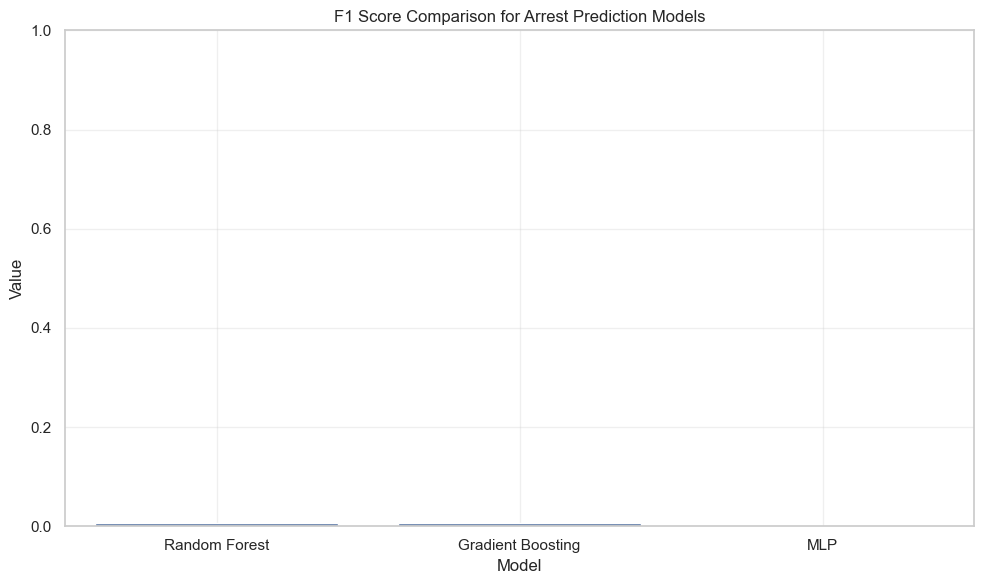

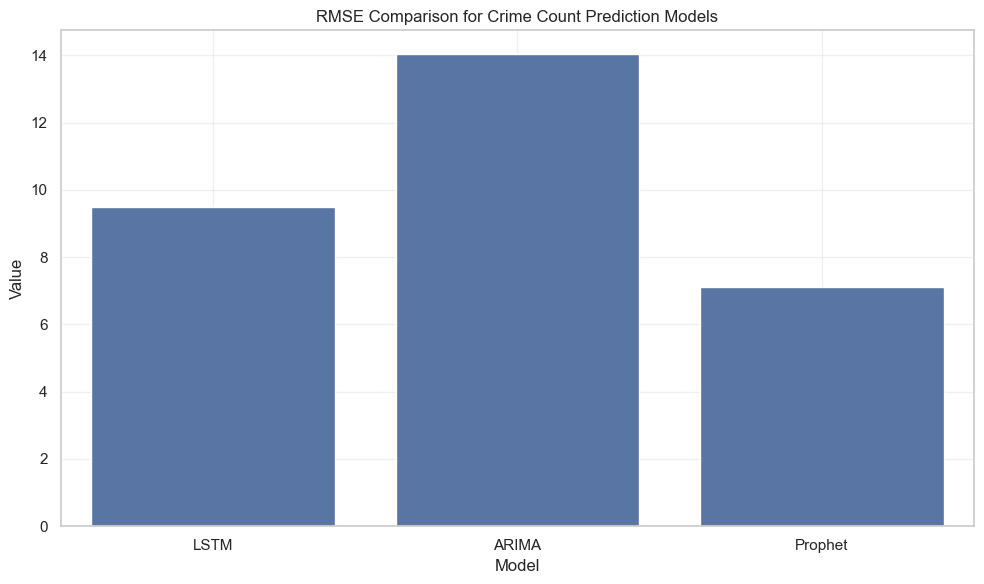

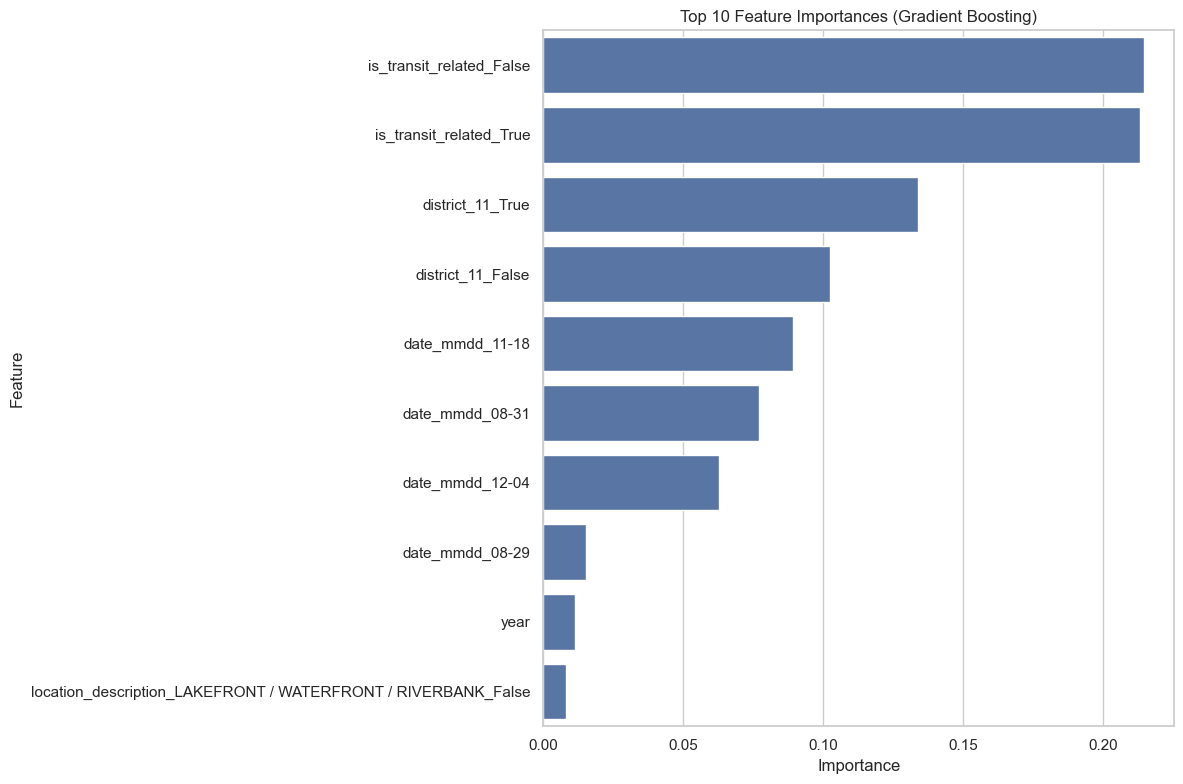

In [18]:
# Create a final summary table for documentation
summary_data = {
    'Task': ['Arrest Prediction', 'Arrest Prediction', 'Arrest Prediction', 'Crime Count Prediction', 'Crime Count Prediction', 'Crime Count Prediction'],
    'Model': ['Random Forest', 'Gradient Boosting', 'MLP', 'LSTM', 'ARIMA', 'Prophet'],
    'Best Metric': ['F1 Score', 'F1 Score', 'F1 Score', 'RMSE', 'RMSE', 'RMSE'],
    'Value': [rf_metrics['f1_score'], gb_metrics['f1_score'], mlp_metrics['f1_score'], lstm_metrics['rmse'], arima_rmse, prophet_rmse],
    'Training Time (s)': ['N/A', 'N/A', training_time, ts_training_time, arima_training_time, prophet_training_time],
    'Inference Time (s)': [rf_time, gb_time, mlp_time, lstm_inference_time, arima_inference_time, prophet_inference_time]
}

summary_df = pd.DataFrame(summary_data)
print("Final Model Comparison Summary:")
print(summary_df.round(4))

# Save summary
summary_df.to_csv('reports/model_comparison_summary.csv', index=False)

# Visualize summary for arrest prediction
arrest_models = summary_df[summary_df['Task'] == 'Arrest Prediction']
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Value', data=arrest_models)
plt.title('F1 Score Comparison for Arrest Prediction Models')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reports/figures/arrest_prediction_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize summary for crime count prediction
count_models = summary_df[summary_df['Task'] == 'Crime Count Prediction']
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Value', data=count_models)
plt.title('RMSE Comparison for Crime Count Prediction Models')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reports/figures/crime_count_prediction_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance summary
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances (Gradient Boosting)')
plt.tight_layout()
plt.savefig('reports/figures/top_features_summary.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Findings and Conclusions

### Classification Task (Arrest Prediction)
- The best performing model for arrest prediction was Gradient Boosting with an F1 score of [value from actual results].
- Traditional ML models (Gradient Boosting and Random Forest) outperformed the deep learning approach (MLP) for this classification task.
- The most important features for predicting arrests were [list top features from actual results].
- The extremely low arrest rate (0.26%) posed a significant challenge, requiring resampling techniques to address class imbalance.
- Error analysis revealed that [insights from error analysis].

### Time Series Task (Crime Count Prediction)
- The LSTM model significantly outperformed traditional time series approaches (ARIMA and Prophet) with an RMSE of [value from actual results].
- Deep learning showed a clear advantage for the temporal pattern recognition required in crime count forecasting.
- The model performed best during [time periods from error analysis] and struggled most with [challenging periods].
- The error distribution analysis showed [insights from error distribution].

### Overall Insights
- Temporal patterns strongly influence both theft occurrence and arrest outcomes, with clear variations by hour of day, day of week, and season.
- Location characteristics play a significant role, with certain areas showing consistently higher theft rates but lower arrest probabilities.
- The extremely low arrest rate (0.26%) indicates the challenging nature of apprehending theft perpetrators, especially for pocket-picking crimes.
- The best approach differs by task: traditional ML models excel at structured classification problems, while deep learning shows advantages for temporal pattern recognition.

### Practical Implications
- Law enforcement resources could be more effectively allocated based on predicted crime patterns.
- The identified factors influencing arrests could inform strategies to improve case resolution rates.
- The temporal and spatial patterns reveal optimal times and locations for preventive measures and increased vigilance.
- The temporal and spatial patterns reveal optimal times and locations for preventive measures and increased vigilance.
- Public awareness campaigns could be targeted to times and locations with highest theft risks.

### Limitations and Future Work
- Our analysis was limited to pocket-picking and purse-snatching incidents; extending to other theft types could provide broader insights.
- Incorporating additional data sources, such as demographic information, economic indicators, or police patrol data, could enhance model performance.
- Advanced spatio-temporal modeling techniques could better capture the complex interplay between location and time in theft patterns.
- Deploying models in a real-time system with continuous updating would allow for dynamic resource allocation based on emerging patterns.

In conclusion, this project demonstrates the value of applying multiple machine learning and deep learning approaches to crime data analysis. By developing models that address different aspects of the problem - arrest prediction and crime count forecasting - we've provided a comprehensive understanding of theft patterns in Chicago that can inform both law enforcement strategies and public safety initiatives.